Fully Bayesian inference for generalized GP models with HMC
--

*James Hensman, 2015, 2016, 2017*

It's possible to construct a very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable since the likelihoods is not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function-values and the parameters $\theta$ jointly. Key to an effective scheme is rotation of the field using the Cholesky decomposition. We write

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over v and the function values is not widely adopted in the literature becate of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in tensorflow, and so application of HMC is relatively straightforward. 

### Exponential Regression example
The first illustration in this notebook is 'Exponential Regression'. The model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. first, generate a data set.

In [1]:
import gpflow
from gpflow.test_util import notebook_niter
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

X = np.linspace(-3,3,20)
Y = np.random.exponential(np.sin(X)**2)

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [2]:
with gpflow.defer_build():
    k = gpflow.kernels.Matern32(1, ARD=False) + gpflow.kernels.Bias(1)
    l = gpflow.likelihoods.Exponential()
    m = gpflow.models.GPMC(X[:,None], Y[:,None], k, l)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [3]:
m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[1].variance.prior = gpflow.priors.Gamma(1., 1.)

Running HMC is pretty similar to optimizing a model. GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two things to tune, the step size (epsilon) and the number of steps [Lmin, Lmax]. Each proposal will take a random number of steps between Lmin and Lmax, each of length epsilon. 

We'll use the `verbose` setting so that we can see the acceptance rate. <- this is broken :(

In [4]:
m.compile()
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m, maxiter=notebook_niter(15)) # start near MAP

In [5]:
s = gpflow.train.HMC()
samples = s.sample(m, notebook_niter(500), epsilon=0.12, lmax=20, lmin=5, thin=5, logprobs=False)#, verbose=True)

In [6]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []
for i, s in samples.iterrows():
    f = m.predict_f_samples(xtest, 5, initialize=False, feed_dict=m.sample_feed_dict(s))
    f_samples.append(f)
f_samples = np.vstack(f_samples)

(-0.1, 3.2763890749508007)

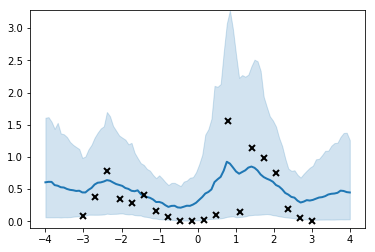

In [7]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

In [8]:
samples.head()

,GPMC/V,GPMC/kern/kernels/0/lengthscales,GPMC/kern/kernels/0/variance,GPMC/kern/kernels/1/variance
0,"[[-1.21828836385], [-0.319760275612], [0.07058...",0.561140,0.056633,2.669075
1,"[[-1.21828836385], [-0.319760275612], [0.07058...",0.561140,0.056633,2.669075
2,"[[-2.222449023], [2.85239361506], [1.037498786...",0.048587,0.034132,1.617707
3,"[[-0.586121746297], [0.587378397531], [-1.3408...",0.450445,0.033564,0.523221
4,"[[-1.33457942445], [1.0519000803], [0.08972336...",0.248194,0.293047,1.035331


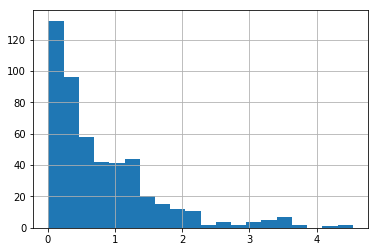

In [9]:
samples['GPMC/kern/kernels/0/variance'].hist(bins=20)